# 参数估计的不稳定性

By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

# 参数

参数是模型用来约束其预测的任何东西。通常，参数是一个有助于描述数据集或分布的量。例如，正态分布的均值是一个参数，实际上，我们说正态分布的均值和方差是<i>参数化的</i>。我们从正态分布中抽取一组样本，取其均值，得到分布的均值的估计值。类似地，一组观测值的平均值是对底层分布(通常被认为是正态分布)参数的估计。其他参数包括中值、与另一个系列的相关系数、标准偏差和数据集的所有其他度量。

## 你永远不知道，你只是估计

当你取一个数据集的平均值时，你并不知道它的平均值。根据已有的数据，你已经尽可能地估计了平均值。估计值可能是错的。这适用于您估计的任何参数。要真正理解发生了什么，你需要通过观察它的稳定性/标准误差/置信区间来确定你的评估有多好。

# 估计的不稳定性

当我们考虑一组观测值时，我们对参数的计算只能是一个估计值。它会随着我们进行更多的测量或者随着时间的推移而变化我们会得到新的观测结果。我们可以通过观察参数在数据的不同子集中是如何变化的，来量化评估中的不确定性。例如，标准差描述了一个集合的均值与每个观测值的均值的不同程度，也就是说，与每个观测值本身的不同程度。在金融应用中，数据通常以时间序列的形式出现。在这种情况下，我们可以在不同的时间点估计一个参数;比如前30天。通过观察这个移动的估计值随着时间窗口的改变而变化的幅度，我们可以计算出估计值的不稳定性。

In [1]:
# We'll be doing some examples, so let's import the libraries we'll need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 例如:均值和标准差

首先，我们来看一些正态分布的样本。我们知道分布的均值是0，标准差是1;但是如果我们从观测中测量参数，我们将得到的是近似0和近似1。我们可以看到这些估计是如何变化的，因为我们采取了越来越多的样本:

-0.26951611032632805
0.027109073490359778
-0.020616059111720507
-0.038643973513210604


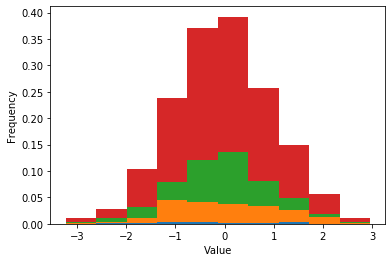

In [2]:
# Set a seed so we can play with the data without generating new random numbers every time
np.random.seed(123)

normal = np.random.randn(500)
print(np.mean(normal[:10])) 
print (np.mean(normal[:100]))
print(np.mean(normal[:250])) 
print(np.mean(normal)) 

# Plot a stacked histogram of the data
plt.hist([normal[:10], normal[10:100], normal[100:250], normal], density=1, histtype='bar', stacked=True);
plt.ylabel('Frequency')
plt.xlabel('Value');

In [3]:
print(np.std(normal[:10])) 
print(np.std(normal[:100])) 
print(np.std(normal[:250])) 
print(np.std(normal)) 

1.236304801499023
1.128240470477961
1.0174604368340197
1.0032028561568238


注意，尽管均值和标准差分别趋近于0和1的概率随样本数量的增加而增加，但我们并不总是通过获取更多的数据点来获得更好的估计值。无论我们的期望是什么，我们总是可以得到不同的结果，我们的目标通常是计算结果与期望有显著差异的概率。

对于时间序列数据，我们通常只关心数据的连续子集。移动平均(也称为运行或滚动)将之前$n$个数据点的平均值分配给每个时间点。下面，我们计算股票价格的90天移动平均线，并绘制它来查看它是如何变化的。一开始是没有结果的，因为我们首先要积累至少90天的数据。

## 示例:非正态基础分布

如果底层数据是非正态的会发生什么?中庸之道是很骗人的。因此，测试数据是否正常是很重要的。我们将使用一个Jarque-Bera测试作为例子。

mean: 0.009847581282146528
standard deviation: 5.060708740105227


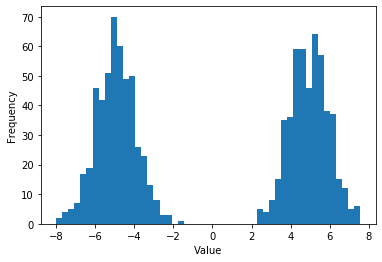

In [4]:
#Generate some data from a bi-modal distribution
def bimodal(n):
    X = np.zeros((n))
    for i in range(n):
        if np.random.binomial(1, 0.5) == 0:
            X[i] = np.random.normal(-5, 1)
        else:
            X[i] =  np.random.normal(5, 1)
    return X
            
X = bimodal(1000)

#Let's see how it looks
plt.hist(X, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Value')
print('mean:', np.mean(X)) 
print ('standard deviation:', np.std(X))

可以肯定的是，这个平均值对于数据中发生的事情并没有提供足够的信息。我们已经将所有的数据压缩到一个单一的估计值中，并因此丢失了大量的信息。如果正态分布的假设是正确的，这就是分布。

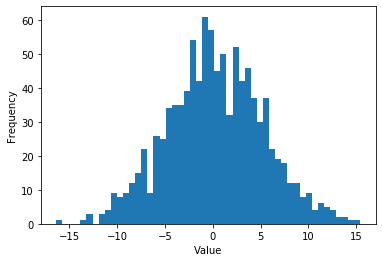

In [8]:
mu = np.mean(X)
sigma = np.std(X)

N = np.random.normal(mu, sigma, 1000)

plt.hist(N, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Value');

我们将使用Jarque-Bera测试来测试我们的数据，看看它是否正态。显著的p值表示非正态性。

In [9]:
from statsmodels.stats.stattools import jarque_bera

jarque_bera(X)

(142.12550136207705,
 1.3735343038981241e-31,
 -0.007644415681800414,
 1.1531707484649847)

确实，这个值< 0.05，我们说X不是正态分布。这避免了我们偶然做出可怕的预测。

# 例如:夏普比率

通常用来描述资产和投资组合表现的一个统计指标是夏普比率(Sharpe ratio)，它衡量的是投资组合每单位额外风险所带来的额外回报，相对于国债等无风险回报来源而言:
$$R = \frac{E[r_a - r_b]}{\sqrt{Var(r_a - r_b)}}$$

其中$r_a$是我们资产的收益率，$r_b$是无风险收益率。与均值和标准差一样，我们可以计算一个滚动的夏普比率，看看我们的估计值如何随时间变化。

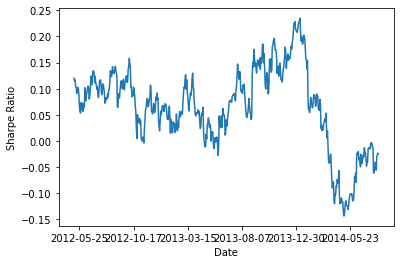

In [12]:
from pandas_datareader import data

def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

start = '2012-01-01'
end = '2015-01-01'
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = data.get_data_yahoo('BIL',start, end)['Close'].pct_change()[1:]
pricing = data.get_data_yahoo('AMZN', start, end)['Close']
returns = pricing.pct_change()[1:] # Get the returns on the asset

# Compute the running Sharpe ratio
running_sharpe = [sharpe_ratio(returns[i-90:i], treasury_ret[i-90:i]) for i in range(90, len(returns))]

# Plot running Sharpe ratio up to 100 days before the end of the data set
_, ax1 = plt.subplots()
ax1.plot(range(90, len(returns)-100), running_sharpe[:-100]);
ticks = ax1.get_xticks().astype(int)
ax1.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio');

夏普比率看起来相当不稳定，很明显，仅仅将其报告为单个值对预测未来值没有太大帮助。相反，我们可以计算上述数据的均值和标准差，然后看看它是否有助于我们预测未来100天的夏普比率。

Mean of running Sharpe ratio: 0.06406517080015282
std of running Sharpe ratio: 0.07774922848487398


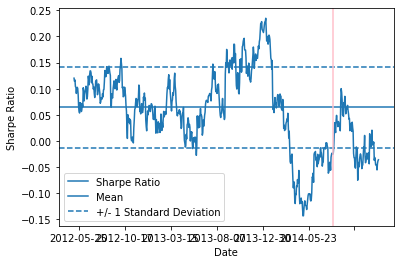

In [13]:
# Compute the mean and std of the running Sharpe ratios up to 100 days before the end
mean_rs = np.mean(running_sharpe[:-100])
std_rs = np.std(running_sharpe[:-100])

# Plot running Sharpe ratio
_, ax2 = plt.subplots()
ax2.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
ax2.plot(range(90, len(returns)), running_sharpe)

# Plot its mean and the +/- 1 standard deviation lines
ax2.axhline(mean_rs)
ax2.axhline(mean_rs + std_rs, linestyle='--')
ax2.axhline(mean_rs - std_rs, linestyle='--')

# Indicate where we computed the mean and standard deviations
# Everything after this is 'out of sample' which we are comparing with the estimated mean and std
ax2.axvline(len(returns) - 100, color='pink');
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

print('Mean of running Sharpe ratio:', mean_rs) 
print ('std of running Sharpe ratio:', std_rs)

这种情况下的标准差大约是范围的四分之一，所以这些数据非常不稳定。尽管我们观察到的数据离均值还有一个标准差远，但在预测未来时，考虑到这一点会比仅仅使用平均值更准确。我们还可以计算夏普比率的滚动平均值来尝试跟踪趋势;但在这种情况下，我们也应该考虑标准差。

## 例子:移动平均

假设取有回望窗口的平均值;如何确定这个估计值的标准误差呢?让我们从一个显示90天移动平均线的例子开始。

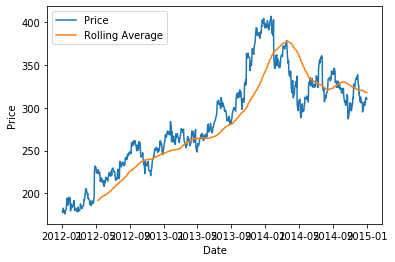

In [16]:
# Load time series of prices
start = '2012-01-01'
end = '2015-01-01'
pricing = data.get_data_yahoo('AMZN', start,end)['Close']

# Compute the rolling mean for each day
mu = pricing.rolling(90).mean()

# Plot pricing data
_, ax1 = plt.subplots()
ax1.plot(pricing) 
plt.ylabel('Price')
plt.xlabel('Date')

# Plot rolling mean
ax1.plot(mu);
plt.legend(['Price','Rolling Average']);

这让我们看到平均值的不稳定性/标准误差，并有助于预测数据的未来可变性。我们可以通过计算滚动平均值的平均值和标准偏差来量化这种变化。

In [17]:
print ('Mean of rolling mean:', np.mean(mu))
print ('std of rolling mean:', np.std(mu))

Mean of rolling mean: 288.38633955239277
std of rolling mean: 51.1351502493079


事实上，我们用来量化可变性的标准差本身就是一个变量。下面我们绘制滚动标准偏差(90天窗口)，并计算其均值和标准偏差。

Mean of rolling std: 17.403827723705366
std of rolling std: 7.5446920824802834


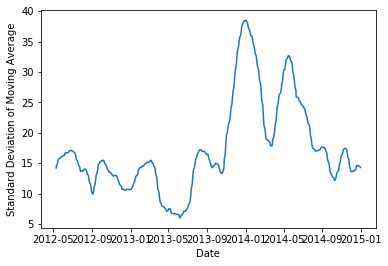

In [18]:
# Compute rolling standard deviation
std = pricing.rolling(90).std()

# Plot rolling std
_, ax2 = plt.subplots()
ax2.plot(std)

plt.ylabel('Standard Deviation of Moving Average')
plt.xlabel('Date')

print ('Mean of rolling std:', np.mean(std))
print ('std of rolling std:', np.std(std))

为了了解这个变化的标准偏差对我们的数据集意味着什么，让我们再次沿着Bollinger带绘制数据:滚动平均值，(数据的)一个滚动标准差高于平均值，一个滚动标准差低于平均值。

请注意，尽管标准偏差为我们提供了关于数据分布的更多信息，但如果不假定潜在过程的特定分布，我们就无法为我们对未来观测的期望分配精确的概率。

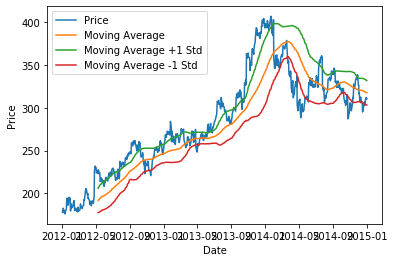

In [19]:
# Plot original data
_, ax3 = plt.subplots()
ax3.plot(pricing)

# Plot Bollinger bands
ax3.plot(mu)
ax3.plot(mu + std)
ax3.plot(mu - std);
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['Price', 'Moving Average', 'Moving Average +1 Std', 'Moving Average -1 Std'])

# 结论

每当我们为一个数据集计算一个参数时，我们也应该计算它的波动性。否则，我们不知道是否应该期望新数据点与此参数对齐。计算波动率的一种好方法是将数据划分为子集，并从中估计每个子集的参数，然后找出结果之间的可变性。在我们的样本期之后，可能仍然会引入一些我们无法预测的外部因素。然而，标准误差的不稳定性分析和测试仍然非常有用，它告诉我们应该在多大程度上不信任我们的估计。